# filTags (DEMO)
This notebook presents **filTags** a method to tag the filters of a convolutional neural network. Therefore important filters related to the classification of a certain class are tagged with the corresponding class label.

It consists of 4 steps:
- A) *Initialization*: configuration of the notebook and data download
- B) *Quantifying Filter Activations*: data preparation, network preparation and computation of the activations
- C) *Tagging Filters*: assignment of the labels
- D) *Visualize filTags*: visualizations of the filter tags

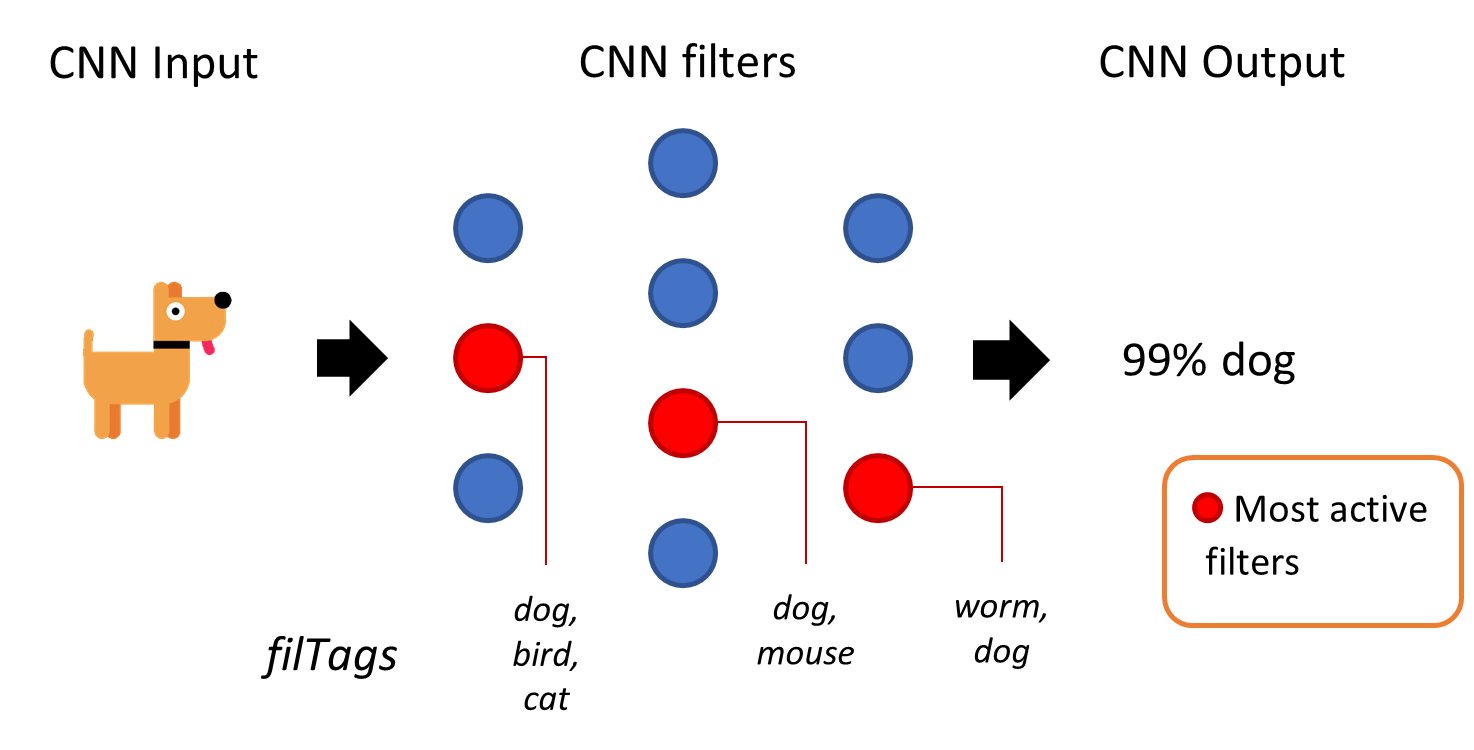

# A) Initialization

## Inputs

Following parameters can be specified:
* network: name of the used network
* k: parameter k for first visualization, determines the number of tags per class and layer
* q: parameter q for second visualization, determines the proportion of tags per class and layer

In [ ]:
network = "VGG16" #@param ["VGG16", "VGG19", "InceptionV3", "ResNet50", "ResNet101", "ResNet152", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionResNetV2"]
k = "25" #@param [1, 2, 5, 10, 25, 50, 100]
q = "5" #@param [1, 2, 5, 10, 25, 50, 100]

## Imports

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import tensorflow as tf
import textwrap
from scipy import ndimage
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.datasets import cifar100
from tqdm.notebook import tqdm

## Get image data

### download CIFAR100

CIFAR100 consists of 50,000 32x32 color training images and 10,000 test images ([Krizhevsky & Hinton 2009](https://www.cs.toronto.edu/~kriz/cifar.html))

In [ ]:
# download dataset CIFAR100 from Keras
cifar=cifar100.load_data(label_mode="fine")
dataset="CIFAR100"

### decoding of CIFAR100

In [ ]:
# decoding of CIFAR100 
word_label = [
'apple',
'aquarium_fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
]

### show some images

In [ ]:
num_show=21

rows=int(num_show/7)+1
for i in range(num_show):
  plt.subplot(rows,7,i+1)
  plt.axis('off')
  plt.imshow(cifar[0][0][i],interpolation='sinc')
  plt.title(word_label[int(cifar[0][1][i])])
plt.gcf().set_size_inches(14,rows*2)
_=plt.gcf().suptitle("Example images of CIFAR100")

# B) Quantifying Filter Activations

In this section the average activations for each feature map and class are computed.

## Quantifying Filter Activations Preprocessing

The network is prepared and the images are further preprocessed. For this demo only the first 200 images of CIFAR are used ot determine the filTags.

In [ ]:
# network
network_mod = {"VGG16": "vgg16", 
               "VGG19": "vgg19", 
               "InceptionV3": "inception_v3", 
               "ResNet50": "resnet",
               "ResNet101": "resnet", 
               "ResNet152": "resnet", 
               "ResNet50V2": "resnet_v2", 
               "ResNet101V2": "resnet_v2",
               "ResNet152V2": "resnet_v2", 
               "InceptionResNetV2": "inception_resnet_v2"}
print("importing "+network +" from Keras")
cnn = getattr(keras.applications, network)()
network_module = getattr(keras.applications, network_mod[network])
layers = [] # interesting layers (conv), omitting pooling layer and fc
layersnames={}
for i, layer in enumerate(cnn.layers):
    layersnames[i]=layer.name
    if 'conv' not in layer.name:
        continue
    layers.append(i)

outputs = [cnn.layers[i].output for i in layers]
outputs_model = keras.Model([cnn.input], outputs)
print(network +" imported")

# data
num_images=200
NUM_CLASSES=len(word_label)
# create subset as tf dataset
(x_train,y_train),(x_test,y_test)=cifar
y_train.astype(np.int16,copy=False)
img_data=tf.data.Dataset.from_tensor_slices((x_train[0:num_images], y_train[0:num_images]))
preprocess_input = getattr(network_module, "preprocess_input")
print("preprocess images")
if "ception" in network:  # Inception networks have other image resolution
    img_size = 299
else:
    img_size = 224

def prep_image(image,label):
  """resize and preprocess image"""
  image=tf.image.resize(image, [img_size, img_size],method="bicubic")
  image=preprocess_input(image)
  return image, label

img_data=img_data.map(prep_image)
print("preprocessing done")

## Quantifying Filter Activations Functions

In [ ]:
def get_activations(imgs, nn_model):
    """
    computes the average activations of prep_images according to nn_model

    input:
    - imgs (list): image data as np.arrays
    - nn_model (keras.model): initialized keras model to obtain the activations

    returns:
    - fm_val: featuremap values (activations of filters)
    """
    for step,img in enumerate(tqdm(imgs,desc='Image',leave=False)):
        raw_acts=nn_model.predict(tf.expand_dims(img,axis=0))
        out_pic_new = scale_out(raw_acts)
        fm_val_new = featuremap_values(out_pic_new)
        if step==0:
            prep_act = fm_val_new.copy()
        else:
            for count, layer in enumerate(prep_act):
                prep_act[count] = (fm_val_new[count] * (1 / (step + 1)) +
                                   fm_val[count] * (step / (step + 1)))
        fm_val = prep_act.copy()
    return fm_val

In [ ]:
def scale_out(act_raw):
    '''
    scales the activations of each layer to a range of [0,1]

    input:
    - act_raw: raw activations

    return:
    - act_scaled: scaled activations
    '''
    act_scaled = act_raw.copy()
    scaler = MinMaxScaler(copy=False)  # inplace operation
    for layer in act_scaled:
        layer = layer.reshape(-1, 1)
        scaler.fit_transform(layer)
    return act_scaled

In [ ]:
def featuremap_values(acts):
    '''
    averages the activations of each feature map to get one single number for 
    each feature map

    input:
    - acts: activations

    return:
    - featuremap_val: feature map values (averaged activations for each feature
      map)
    '''
    featuremap_val = [[] for x in range(len(acts))]
    for i, layer in enumerate(acts):
        featuremap_val[i] = layer.mean(axis=(0,1,2))
    return featuremap_val

## Quantifying Filter Activations Get Activations

In [ ]:
out={}
print("computing activations")
for i in tqdm(range(NUM_CLASSES),desc='Class'):
    class_images = img_data.filter(lambda img, label: tf.math.equal(label[0], i))
    class_images = [x for x,y in class_images]
    if not class_images:
      continue
    out[i] = get_activations(class_images, outputs_model)

# C) Tagging Filters

For each class, the k or q% of feature maps with the highest values per layer are selected and the corresponding preceding filters are assigned the class label. This results in k or q% labels per layer, respectively. 

## Tagging Filters Functions

In [ ]:
def set_threshold(fil_act,k_q,percent=False):
  '''
  determines the most active filters by choosing the k or q% highest average 
  activations

  input:
    fil_act: (averaged) activation of filters
    k_q: number indicating used method for threshold. 0 for layer average as 
    threshold, else k or k%-most activations per layer
    percent: boolean wether q-percent most active filters or k-most active filters
  
  output:
    fil_act_t: thresholded 'most active' filters
  '''
  fil_act_t=fil_act.copy()
  for i,layer in enumerate(fil_act_t):
    l=k_q
    if percent:
      con=100
    else:
      con=len(layer)
    #select threshold method:
    if k_q>con:# k_q too big for layer, k_q is set to 0 (average)
      l=0
      threshold=np.average(layer)
      ind=np.nonzero(layer>threshold)
    elif k_q<0: # k_q too small. k_q is set to 0 (average) for all layers
      k_q=0
      l=0
      threshold=np.average(layer)
      ind=np.nonzero(layer>threshold)
    else:
      if percent:
        p=int(round((l/100)*len(layer)))
        ind=np.argpartition(layer, -p)[-p:]
      else:
        ind=np.argpartition(layer, -l)[-l:]
    fil_act_t[i]=np.zeros(len(fil_act_t[i]))
    fil_act_t[i][ind]=1
  return fil_act_t

In [ ]:
def label_it(fil_act_t,label,labels_old=[]):
  '''
  labels the most active filters for each class with corresponding class label, adds label to labels_old for all filters above threshold determined by fil_act

  inputs:
  - fil_act_t: thresholded active filters; list with np-arrays for each layer as elements; these np-arrays contain the thresholded activations (0:filter inactive, 1: filter active)
  - label: name of the class
  - labels_old: list with labels (3.dim) of each filter (2.dim) of each layer (1.dim)

  returns:
  - labels_new: updated list of labels
  '''
  if not fil_act_t:
    print("Warning: label_it input is empty for this class")
    return []
    
  if not labels_old: #initialization
    labels_old=[None]*len(fil_act_t)
    for count,layerf in enumerate(fil_act_t):
      labels_old[count]=[None]*len(layerf)
      for step,filterf in enumerate(layerf):
        labels_old[count][step]=[]
  for count,layerf in enumerate(fil_act_t):
    for step,filterf  in enumerate(layerf):
      if filterf==1.0: #append if active
        labels_old[count][step].append(label)
  labels_new=labels_old
  return labels_new

## Tagging Filters Get Labels

In [ ]:
# k-labels
k_q=[1,2,5,10,25,50,100]
print("Computing filTags for different k")
filterlabels_k={}
for i,el in enumerate(tqdm(k_q,desc="k")):
  labels_filters=[]
  for j in tqdm(range(NUM_CLASSES),desc="class",leave=False):
    try:
      fil_act_t=set_threshold(out[j],el,False)
    except KeyError:
      continue
    labels_filters=label_it(fil_act_t,word_label[j],labels_filters)
  filterlabels_k[el]=labels_filters

In [ ]:
# q%-labels
print("Computing filTags for different q%")
filterlabels_q={}
for i,el in enumerate(tqdm(k_q,desc="q%")):
  labels_filters=[]
  for j in tqdm(range(NUM_CLASSES),desc="class",leave=False):
    try:
      fil_act_t=set_threshold(out[j],el,True)
    except:
      continue
    labels_filters=label_it(fil_act_t,word_label[j],labels_filters)
  filterlabels_q[el]=labels_filters

# D) Visualize filTags

The filTags of the last 7 convolutional layers of the selected network are visualized depending on the choices for k and q. 

### k labels per layer
Visualization of filTags depending on k.

In [ ]:
# prepare filTags
k=int(k)
show_last_layers=7 # change this parameter to show more or less layers
filTags = filterlabels_k[k]
layersize = []
assert isinstance(filTags, list)
num_layers =len(filTags)
if show_last_layers>num_layers:
  show_last_layers=num_layers
for i in range(num_layers-show_last_layers,num_layers):
    layersize.append(len(filTags[i]))
layersize_cum = list(np.cumsum(layersize))
layersize_cum.append(0)

# create graph
print("computing graph")
G = nx.Graph()
node_dict=[]
num_nodes=layersize_cum[-2]
layer=0
for i in tqdm(range(num_nodes)):
  if i in layersize_cum:
    layer+=1
  node_dict.append((i,{'subset':layer}))
G.add_nodes_from(node_dict)
print("graph ready")

# create annotation (node trace)
print("annotate graph")
node_trace = go.Scatter(x=[], y=[], text=[],
                        textposition="top center",
                        textfont_size=10,
                        mode='markers+text',
                        hoverinfo='text',
                        hovertext=[],
                        marker=dict(color='orange',
                                    size=10,
                                    line=None))
pos = nx.multipartite_layout(G)
layer = (num_layers)-(show_last_layers)-1
fil = 0
for count, node in enumerate(tqdm(G.nodes())):
    if count in layersize_cum:
        layer += 1
        fil = 0
        node_trace['text'] += tuple(['<b>' + layersnames[layers[layer]] + '</b>'])
    else:
        node_trace['text'] += tuple(' ')
        fil += 1
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    num_Tags = len(filTags[layer][fil])
    if num_Tags > 50:
        filTags_temp = str(filTags[layer][fil][0:50])
        node_trace['hovertext'] += tuple(['<b>' + layersnames[layers[layer]] + ',fil ' + str(fil) + '</b><br>' + '<br>'.join(
            textwrap.wrap(filTags_temp, width=100)) + "<i> (and " + str(num_Tags - 50) + " more</i>)"])
    else:
        filTags_temp = str(filTags[layer][fil])
        node_trace['hovertext'] += tuple(['<b>' + layersnames[layers[layer]] + ',fil ' + str(fil) + '</b><br>' + '<br>'.join(
            textwrap.wrap(filTags_temp, width=100))])
print("annotation ready")

# plot with plotly
print("plotting graph")
layout = go.Layout(paper_bgcolor='rgba(0,38,77,1)',  # dark blue frame
                   plot_bgcolor='rgba(255,255,255,1)',  # white background
                   xaxis={'showgrid': False, 'zeroline': False},  # no gridlines
                   yaxis={'showgrid': False, 'zeroline': False},  # no gridlines
                   title={'text':"FilTags of " + network + " with k=" + str(k),
                          'font':  dict(family="Arial",size=18, color="white"),
                          'xanchor': 'center',
                          'x':0.5})
config = dict({'modeBarButtonsToRemove': ['toggleSpikelines', 
                                          'hoverCompareCartesian', 
                                          'select2d', 'lasso2d',
                                          'autoScale2d']})
fig = go.Figure(layout=layout)
fig.add_trace(node_trace)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show(config=config)
fig.write_html('filTags-k'+ str(k) +'-hr-'+network+'.html')

### q% labels per layer
Visualization of filTags depending on q.

In [ ]:
# prepare filTags
q=int(q)
show_last_layers=7 # change this parameter to show more or less layers

filTags = filterlabels_q[q]
layersize = []
assert isinstance(filTags, list)
num_layers =len(filTags)
if show_last_layers>num_layers:
  show_last_layers=num_layers
for i in range(num_layers-show_last_layers,num_layers):
    layersize.append(len(filTags[i]))
layersize_cum = list(np.cumsum(layersize))
layersize_cum.insert(0,0)

# create graph
print("computing graph")
G = nx.Graph()
node_dict=[]
num_nodes=layersize_cum[-1]
layer=0
for i in tqdm(range(num_nodes)):
  if i in layersize_cum:
    layer+=1
  node_dict.append((i,{'subset':layer}))
G.add_nodes_from(node_dict)
print("graph ready")

# create annotation (node trace)
print("annotate graph")
node_trace = go.Scatter(x=[], y=[], text=[],
                        textposition="top center",
                        textfont_size=10,
                        mode='markers+text',
                        hoverinfo='text',
                        hovertext=[],
                        marker=dict(color='orange',
                                    size=10,
                                    line=None))
pos = nx.multipartite_layout(G)
layer = (num_layers)-(show_last_layers)-1
fil = 0
for count, node in enumerate(tqdm(G.nodes())):
    if count in layersize_cum:
        layer += 1
        fil = 0
        node_trace['text'] += tuple(['<b>' + layersnames[layers[layer]] + '</b>'])
    else:
        node_trace['text'] += tuple(' ')
        fil += 1
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    num_Tags = len(filTags[layer][fil])
    if num_Tags > 50:
        filTags_temp = str(filTags[layer][fil][0:50])
        node_trace['hovertext'] += tuple(['<b>' + layersnames[layers[layer]] + ',fil ' + str(fil) + '</b><br>' + '<br>'.join(
            textwrap.wrap(filTags_temp, width=100)) + "<i> (and " + str(num_Tags - 50) + " more</i>)"])
    else:
        filTags_temp = str(filTags[layer][fil])
        node_trace['hovertext'] += tuple(['<b>' + layersnames[layers[layer]] + ',fil ' + str(fil) + '</b><br>' + '<br>'.join(
            textwrap.wrap(filTags_temp, width=100))])
print("annotation ready")

# plot with plotly
print("plotting graph")
layout = go.Layout(paper_bgcolor='rgba(0,38,77,1)',  # dark blue frame
                   plot_bgcolor='rgba(255,255,255,1)',  # white background
                   xaxis={'showgrid': False, 'zeroline': False},  # no gridlines
                   yaxis={'showgrid': False, 'zeroline': False},  # no gridlines
                   title={'text':"FilTags of " + network + " with q=" + str(q),
                          'font':  dict(family="Arial",size=18, color="white"),
                          'xanchor': 'center',
                          'x':0.5})
fig = go.Figure(layout=layout)
fig.add_trace(node_trace)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show(config=config)
fig.write_html('filTags-q'+ str(q) +'-hr-'+network+'.html')